# Hypothesis Testing - House prices in college towns are less affected during times of recession

In this project, I would test the hypothesis that house prices in college towns are less affected during times of recession. This project covers a lot of Pandas functionality for data cleaning, exploratory analysis and dataframe merging. It also covers an independent t-test for Hypothesis Testing using the scipy.stats module. 

**Hypothesis**: University towns have their mean housing prices less effected by recessions. We will run a t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the recession bottom. (`price_ratio=quarter_before_recession/recession_bottom`)

We use the following data files for this project:
* From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States. In particular the datafile for [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), ```City_Zhvi_AllHomes.csv```, has median home sale prices.
* From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States) which has been copied and pasted into the file ```university_towns.txt```.
* From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp) of the United States in current dollars, in quarterly intervals, in the file ```gdplev.xls```. We are looking only at the 2009 recession so we focus on the GDP data from the first quarter of 2000 onward.

We use the following definitions:

Definitions:
* A _quarter_ is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.
* A _recession_ is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.
* A _recession bottom_ is the quarter within a recession which had the lowest GDP.
* A _college town_ is a city which has a high percentage of university students compared to the total population of the city (we use the list from Wikipedia for this).

### Importing the necessary packages and setting Pandas display option

In [58]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 20)

### Getting the dataframe of college towns and the states they are in

This requires the following cleaning:
1. Renaming the columns to state and region name
2. The first set of characters before the '(' should be the state name, the set of characters in the parenthesis is
   the region name
3. The trailing numbers in the parenthesis should be removed


In [88]:
#String Extracting test

x = 'Auburn (Auburn University)[]'

index_p = x.index('(')

y = x[:index_p]

print(index_p)

print(y)
print(len(y))

y = y.strip()

print(y)

print(len(y))

7
Auburn 
7
Auburn
6


In [89]:
def get_list_of_university_towns():
    
    uni_towns_data = pd.read_csv('university_towns.txt', sep='delimiter', header=None, engine='python')
    
    uni_towns_data.columns = ['Towns']         #rename column name
    
    uni_towns_data['Towns'] = uni_towns_data['Towns'].map(lambda x: x.strip())  #remove whitespace
    
    state_region = []
    
    for i in uni_towns_data['Towns']:
        if '[edit]' in i:                #if the string '[edit] in the Towns column'
            state_name = i[:-6]               #state name is everything except the '[edit]'
        elif '(' in i:
            index_p = i.index('(')           #index of the parenthesis
            region_name = i[:index_p - 1]    #region_name is everything before the '('
            state_region.append([state_name,region_name])
        else:
            region_name = i                       # there are some entries without parenthesis
            state_region.append([state_name,region_name])
            
    college_df = pd.DataFrame(state_region, columns=['State','RegionName'])
    
    return college_df    

In [90]:
get_list_of_university_towns()

,State,RegionName
0,Alabama,Auburn
1,Alabama,Florence
2,Alabama,Jacksonville
3,Alabama,Livingston
4,Alabama,Montevallo
5,Alabama,Troy
6,Alabama,Tuscaloosa
7,Alabama,Tuskegee
8,Alaska,Fairbanks
9,Arizona,Flagstaff


### Loading and cleaning the GDP data: 

From Bureau of Economic Analysis, US Department of Commerce, the GDP over time of the United States in current dollars (we will use the chained value in 2009 dollars), in quarterly intervals, is downloaded in the file gdplev.xls. For this we use the GDP from 2000 onwards.

In [91]:
def clean_gdp_data():
    
    gdp_data = pd.read_excel('gdplev.xls')
    
    gdp_data.drop(gdp_data.columns[[0, 1, 2, 3, 5, 7]], axis=1,inplace=True) #drop the columns we do not need
    
    gdp_data = gdp_data[219:284]    #drop the rows we do not need
    
    gdp_data.rename(columns={'Unnamed: 4': 'Quarter','Unnamed: 6':'GDP'}, inplace=True)  #rename the columns
    
    return gdp_data

In [92]:
clean_gdp_data()

,Quarter,GDP
219,2000q1,12359.1
220,2000q2,12592.5
221,2000q3,12607.7
222,2000q4,12679.3
223,2001q1,12643.3
224,2001q2,12710.3
225,2001q3,12670.1
226,2001q4,12705.3
227,2002q1,12822.3
228,2002q2,12893


<Figure size 720x576 with 0 Axes>

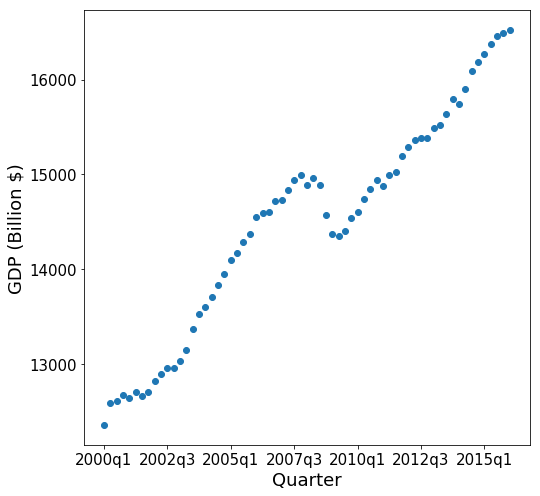

In [93]:
gdp_data = clean_gdp_data()
#gdp_data.plot(x='Quarter', y='GDP', kind = 'scatter', figsize=(10, 6));
import matplotlib.ticker as ticker
plt.figure(figsize=(10,8))

fig, ax = plt.subplots(figsize=(8,8))

s = ax.scatter(gdp_data.Quarter, gdp_data.GDP)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xlabel('Quarter', size = 18)
plt.ylabel('GDP (Billion $)', size = 18)
plt.tick_params(labelsize=15)

So we see that the Recession starts around 2008 and ends around 2009. 

### Obtaining the start of the recession. 
A recession is defined as starting with two consecutive quarters of GDP decline and ending with two quarters of GDP growth.

In [108]:
def get_recession_start(): 
    
    gdp_data = clean_gdp_data()
    
    for i in range(1, len(gdp_data)):
        if (gdp_data.iloc[i+2]['GDP'] < gdp_data.iloc[i+1]['GDP']) and \
           (gdp_data.iloc[i+1]['GDP'] < gdp_data.iloc[i]['GDP']):
            
            recession_start = gdp_data.iloc[i+1]['Quarter']
            
            return recession_start        

In [109]:
get_recession_start()

'2008q3'

### Obtaining the end of the recession

In [178]:
def get_recession_end():
    
    gdp_data = clean_gdp_data()
    
    gdp_data.index = pd.RangeIndex(start=0, stop = len(gdp_data), step=1)  #rename index from 0
    
    recession_start = get_recession_start()
    
    recession_start_index = gdp_data[gdp_data['Quarter']==recession_start].index.item()  #find index of start of recession
      
    gdp_data = gdp_data.iloc[recession_start_index:]
    
    for i in range(0, len(gdp_data)):
        if (gdp_data.iloc[i+2]['GDP'] > gdp_data.iloc[i+1]['GDP']) and \
           (gdp_data.iloc[i+1]['GDP'] > gdp_data.iloc[i]['GDP']):
            recession_end = gdp_data.iloc[i+2]['Quarter']
            return recession_end

In [179]:
get_recession_end()

'2009q4'

### Obtaining the bottom of the recession

A recession bottom is the quarter within a recession which had the lowest GDP.

In [205]:
def get_recession_bottom():
    
    gdp_data = clean_gdp_data()
    
    gdp_data.index = pd.RangeIndex(start=0, stop = len(gdp_data), step=1)  #rename index from 0
    
    recession_start = get_recession_start()
    
    recession_start_index = gdp_data[gdp_data['Quarter']==recession_start].index.item()  #find index of start of recession
      
    recession_end = get_recession_end()
    
    recession_end_index = gdp_data[gdp_data['Quarter']==recession_end].index.item() #find index of end of recession 
    
    gdp_data = gdp_data[recession_start_index:recession_end_index]
    
    gdp_data.sort_values(by='GDP',ascending=True, inplace=True) #sort Top15 by averageGDP
    
    return gdp_data['Quarter'].iloc[0]

In [206]:
get_recession_bottom()

'2009q2'

## Housing Data

Next we get and clean the house price data. We perform the following actions:
1. Remove Region ID, Metro, County Name, SizeRank
2. Convert the price data to quarters. A quarter is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December. We only keep columns for 2000q1 through 2016q3
3. Map the state names to state ids using the dictionary given below
4. Set both state and region name as index


In [229]:
# We will use this dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 
          'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 
          'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 
          'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 
          'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 
          'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 
          'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 
          'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana',
          'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 
          'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 
          'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 
          'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 
          'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 
          'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 
          'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 
          'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 
          'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 
          'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [230]:
def house_price_clean():
    
    house_price = pd.read_csv('City_Zhvi_AllHomes.csv')
    
    house_price.drop(house_price.columns[[0, 3, 4, 5]], axis=1,inplace=True)
    
    for i in range(2000,2017):
        if i == 2016:
            house_price[str(i) + 'q1'] = house_price[[str(i)+'-01', str(i)+'-02', str(i)+'-03']].mean(axis=1)
            house_price[str(i) + 'q2'] = house_price[[str(i)+'-04', str(i)+'-05', str(i)+'-06']].mean(axis=1)
            house_price[str(i) + 'q3'] = house_price[[str(i)+'-07', str(i)+'-08']].mean(axis=1)
        else:
            house_price[str(i) + 'q1'] = house_price[[str(i)+'-01', str(i)+'-02', str(i)+'-03']].mean(axis=1)
            house_price[str(i) + 'q2'] = house_price[[str(i)+'-04', str(i)+'-05', str(i)+'-06']].mean(axis=1)
            house_price[str(i) + 'q3'] = house_price[[str(i)+'-07', str(i)+'-08', str(i)+'-09']].mean(axis=1)
            house_price[str(i) + 'q4'] = house_price[[str(i)+'-10', str(i)+'-11', str(i)+'-12']].mean(axis=1)
            
    drop_list = list(range(2,247))   #list of columns to be dropped (1996 to 1999 data)
    
    house_price.drop(house_price.columns[drop_list], axis=1,inplace=True)
    
    house_price['State'] = house_price['State'].map(states)     #map the state names to the states dictionary created earlier
    
    house_price.set_index(['State','RegionName'],inplace=True)  #change index
    
    return house_price

In [231]:
house_price_clean()

,,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,...,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
State,RegionName,,,,,,,,,,,,,,,,,,,,,
New York,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,515466.666667,522800.000000,528066.666667,532266.666667,540800.000000,557200.000000,572833.333333,582866.666667,591633.333333,587200.0
California,Los Angeles,207066.666667,214466.666667,220966.666667,226166.666667,233000.000000,239100.000000,245066.666667,253033.333333,261966.666667,272700.000000,...,498033.333333,509066.666667,518866.666667,528800.000000,538166.666667,547266.666667,557733.333333,566033.333333,577466.666667,584050.0
Illinois,Chicago,138400.000000,143633.333333,147866.666667,152133.333333,156933.333333,161800.000000,166400.000000,170433.333333,175500.000000,177566.666667,...,192633.333333,195766.666667,201266.666667,201066.666667,206033.333333,208300.000000,207900.000000,206066.666667,208200.000000,212000.0
Pennsylvania,Philadelphia,53000.000000,53633.333333,54133.333333,54700.000000,55333.333333,55533.333333,56266.666667,57533.333333,59133.333333,60733.333333,...,113733.333333,115300.000000,115666.666667,116200.000000,117966.666667,121233.333333,122200.000000,123433.333333,126933.333333,128700.0
Arizona,Phoenix,111833.333333,114366.666667,116000.000000,117400.000000,119600.000000,121566.666667,122700.000000,124300.000000,126533.333333,128366.666667,...,164266.666667,165366.666667,168500.000000,171533.333333,174166.666667,179066.666667,183833.333333,187900.000000,191433.333333,195200.0
Nevada,Las Vegas,132600.000000,134366.666667,135400.000000,137000.000000,139533.333333,141733.333333,143366.666667,146133.333333,149333.333333,150933.333333,...,170066.666667,173400.000000,175466.666667,177500.000000,181600.000000,186766.666667,190633.333333,194600.000000,197200.000000,199950.0
California,San Diego,222900.000000,234366.666667,245433.333333,256033.333333,267200.000000,276266.666667,284500.000000,291933.333333,301233.333333,312866.666667,...,480200.000000,489033.333333,496433.333333,503366.666667,512066.666667,519766.666667,525466.666667,529333.333333,536233.333333,539750.0
Texas,Dallas,84466.666667,83866.666667,84866.666667,87833.333333,89733.333333,89300.000000,89066.666667,90900.000000,92566.666667,93800.000000,...,106633.333333,108900.000000,111533.333333,113700.000000,121133.333333,128566.666667,134600.000000,140500.000000,144600.000000,149300.0
California,San Jose,374266.666667,406566.666667,431866.666667,455500.000000,470666.666667,470200.000000,456800.000000,445566.666667,441433.333333,457766.666667,...,679400.000000,697033.333333,714933.333333,731433.333333,756733.333333,776400.000000,789133.333333,803600.000000,818933.333333,822200.0


### We are finally ready to move towards the hypothesis testing stage 

To prepare the data for the hypothesis testing we do the following:

1. Obtain the start and bottom quarter of the recession using the functions created earlier
2. Add a new column called 'Price Change' which is the difference of the house prices during the start of the recession and the bottom at the house price data frame
3. We then merge the college town and house price data to a new dataframe called 'collegetown_houseprice' using an inner join. This would have the towns common to both house_price_data and the college_town_data
4. We then add a column called "Is a college town" to the dataframe 'collegetown_houseprice' all of whose values are True
5. We next outer join the 'collegetown_houseprice' and "house_price_data" dataframes. All the missing values in the "Is a college town" are filled with "False"

Therefore in the final dataframe "house_price_data" there is the price change column and the "Is a college town" column which we would focus on.

In [344]:
def get_final_data():
    
    college_town_data = get_list_of_university_towns() #get the dataframe of college towns
    
    house_price_data = house_price_clean()

    recession_start = get_recession_start()
    recession_bottom = get_recession_bottom()
    
    
    #we add a new column to house_price_data
    house_price_data['Price Change'] = house_price_data[recession_start] - house_price_data[recession_bottom]
    
    
    #we retain only the college towns whose price data is available and get their prices
    #we do a merge with inner join on both the State and RegionName
    collegetown_houseprice = pd.merge(house_price_data, college_town_data, how ='inner', on=['State', 'RegionName']) 
    
    #we next add a column to the dataframe which would tell us if the town is a college town
    #These are all true now
    collegetown_houseprice['Is a college town'] = True
    
    #We next merge this back with the house_price_data dataframe. This would be an outer join since we 
    #want all the elements of both the dataframes
    
    house_price_data = pd.merge(house_price_data, collegetown_houseprice, how ='outer', 
                                on=['State', 'RegionName', recession_start, recession_bottom, 'Price Change'])
    
    #The N/A values in the "Is a college town" column are the ones which are not college towns. We fill these 
    #with False
    
    house_price_data['Is a college town'] = house_price_data['Is a college town'].fillna(False)
         
    return house_price_data    

In [345]:
get_final_data()

,State,RegionName,2000q1_x,2000q2_x,2000q3_x,2000q4_x,2001q1_x,2001q2_x,2001q3_x,2001q4_x,...,2014q3_y,2014q4_y,2015q1_y,2015q2_y,2015q3_y,2015q4_y,2016q1_y,2016q2_y,2016q3_y,Is a college town
0,New York,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,Los Angeles,207066.666667,214466.666667,220966.666667,226166.666667,233000.000000,239100.000000,245066.666667,253033.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Illinois,Chicago,138400.000000,143633.333333,147866.666667,152133.333333,156933.333333,161800.000000,166400.000000,170433.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Pennsylvania,Philadelphia,53000.000000,53633.333333,54133.333333,54700.000000,55333.333333,55533.333333,56266.666667,57533.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,Arizona,Phoenix,111833.333333,114366.666667,116000.000000,117400.000000,119600.000000,121566.666667,122700.000000,124300.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
5,Nevada,Las Vegas,132600.000000,134366.666667,135400.000000,137000.000000,139533.333333,141733.333333,143366.666667,146133.333333,...,173400.000000,175466.666667,177500.000000,181600.000000,186766.666667,190633.333333,194600.000000,197200.000000,199950.0,True
6,California,San Diego,222900.000000,234366.666667,245433.333333,256033.333333,267200.000000,276266.666667,284500.000000,291933.333333,...,489033.333333,496433.333333,503366.666667,512066.666667,519766.666667,525466.666667,529333.333333,536233.333333,539750.0,True
7,Texas,Dallas,84466.666667,83866.666667,84866.666667,87833.333333,89733.333333,89300.000000,89066.666667,90900.000000,...,108900.000000,111533.333333,113700.000000,121133.333333,128566.666667,134600.000000,140500.000000,144600.000000,149300.0,True
8,California,San Jose,374266.666667,406566.666667,431866.666667,455500.000000,470666.666667,470200.000000,456800.000000,445566.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9,Florida,Jacksonville,88600.000000,89700.000000,91700.000000,93100.000000,94400.000000,95600.000000,97066.666667,99066.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


### Hypothesis Testing

We are ready to use the independent t-test to test the hypothesis.

We test it on the 'Price Change' columns of the college towns and non-college towns. 

The results we print are:

Different: True if the p value is less than 0.01 else False

p: The p value of the test

Better: The type of towns with less price change

In [346]:
def test_hypothesis():
    
    house_price_data = get_final_data()
    
    is_college_towns = house_price_data[house_price_data['Is a college town'] == True]
    
    not_college_towns = house_price_data[house_price_data['Is a college town'] == False]
    
    t, p = ttest_ind(is_college_towns['Price Change'].dropna(), not_college_towns['Price Change'].dropna())
    
    different = True if p < 0.01 else False
    
    better = "university town" if is_college_towns['Price Change'].mean() < not_college_towns['Price Change'].mean() else "non-university town"
    
    return different, p, better

In [347]:
test_hypothesis()

(True, 0.004325214853511201, 'university town')